# Intersubject correlation analysis

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML
from templateflow.api import get
import subprocess


## Getting parcellations 

The atlas namings correspond to the original FSL’s acronyms for them 

* HOCPAL=Harvard-Oxford Cortical Probabilistic Atlas Lateralized 
- 48 regions for both sides total of 96
* HOSPA=Harvard-Oxford Subcortical Probabilistic Atlas
- 21 regions


## Sample mask into functional space
I used fslmeants to get the timeseries per parcel (cortical and subcortical) the masks were first sampled into subject space from 1mm to 3mm.

In [3]:
datapath = '/projects/niblab/experiments/bromocriptine/data/fmriprep/'
altaspath = '/projects/niblab/parcellations/Harvard_Oxford'
outpath = '/projects/niblab/data/BRO/timeseries'

## Making a dictonary with the labels for the ROIS

In [21]:
cort_labels = pd.read_csv(os.path.join(outpath,'atlas.csv'), header = None)

In [93]:
cort_dict = {}

for index, row in cort_labels.iterrows():
    ROW = row[0].split(' ')
    name1 = ROW[5]
    name2 = ROW[6]
    if '%s_%s'%(name1, name2) in cort_dict.values():
        cort_dict.update({int(ROW[1].split('=')[-1]):'%s_%s_%s'%(name1, name2, index)})
    else:
        cort_dict.update({int(ROW[1].split('=')[-1]):'%s_%s'%(name1, name2)})

In [17]:
subcort_labels = pd.read_csv(os.path.join(outpath,'atlas_sub.csv'), header = None, delimiter = ' ')

In [68]:
subcort_dict = {}
for index, row in subcort_labels.iterrows():
    ROW = row[0].split(' ')
    name1 = ROW[15]
    name2 = ROW[16]
    name3 = ROW[17]
    subcort_dict.update({int(ROW[3]):'%s_%s_%s'%(name1, name2, name3)})

In [62]:
import pdb

In [94]:
data_dict = {}
for x in glob.glob(os.path.join(outpath,'cortical_masks','*.txt')):
    sub = x.split('/')[-1].split('_')[0]
    ses = x.split('/')[-1].split('_')[1]
    run = x.split('/')[-1].split('_')[2].split('.')[0]
    print('%s %s %s'%(sub, ses, run))
    df = pd.read_csv(x, header = None, delimiter = '  ')
    df.rename(columns=cort_dict, inplace = True)
    df2 = pd.read_csv(os.path.join(outpath,'subcortical_masks','%s_%s_%s.txt'%(sub,ses,run)), header = None, delimiter = '  ')
    df2.rename(columns=subcort_dict, inplace = True)
    data_dict.update({'%s_%s_%s'%(sub,ses,run):df.join(df2)})
    
    
    

sub-007 ses-1 run-1
sub-008 ses-1 run-1
sub-009 ses-1 run-1
sub-020 ses-1 run-1
sub-011 ses-1 run-1
sub-004 ses-1 run-1
sub-003 ses-1 run-1
sub-012 ses-1 run-1
sub-010 ses-1 run-1


/home/gshearre/miniconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


sub-044 ses-1 run-1
sub-022 ses-1 run-1
sub-052 ses-1 run-1
sub-016 ses-1 run-1
sub-013 ses-1 run-1
sub-026 ses-1 run-1
sub-035 ses-1 run-1
sub-039 ses-1 run-1
sub-025 ses-1 run-1
sub-017 ses-1 run-1
sub-023 ses-1 run-1
sub-029 ses-1 run-1
sub-030 ses-1 run-1
sub-038 ses-1 run-1
sub-046 ses-1 run-1
sub-036 ses-1 run-1
sub-033 ses-1 run-1
sub-040 ses-1 run-1
sub-047 ses-1 run-1
sub-028 ses-1 run-1
sub-019 ses-1 run-1
sub-053 ses-1 run-1
sub-045 ses-1 run-1
sub-043 ses-1 run-1
sub-051 ses-1 run-1
sub-032 ses-1 run-1
sub-041 ses-1 run-1
sub-038 ses-1 run-2
sub-032 ses-1 run-2
sub-003 ses-1 run-2
sub-040 ses-1 run-2
sub-036 ses-1 run-2
sub-046 ses-1 run-2
sub-043 ses-1 run-2
sub-009 ses-1 run-2
sub-007 ses-1 run-2
sub-035 ses-1 run-2
sub-033 ses-1 run-2
sub-053 ses-1 run-2
sub-041 ses-1 run-2
sub-004 ses-1 run-2
sub-010 ses-1 run-2
sub-044 ses-1 run-2
sub-019 ses-1 run-2
sub-039 ses-1 run-2
sub-022 ses-1 run-2
sub-047 ses-1 run-2
sub-023 ses-1 run-2
sub-012 ses-1 run-2
sub-045 ses-1 run-2


In [95]:
list(data_dict['sub-007_ses-1_run-1'].columns)

['Frontal_Pole/label',
 'Insular_Cortex/label',
 'Superior_Frontal',
 'Middle_Frontal',
 'Inferior_Frontal',
 'Inferior_Frontal_5',
 'Precentral_Gyrus/label',
 'Temporal_Pole/label',
 'Superior_Temporal',
 'Superior_Temporal_9',
 'Middle_Temporal',
 'Middle_Temporal_11',
 'Middle_Temporal_12',
 'Inferior_Temporal',
 'Inferior_Temporal_14',
 'Inferior_Temporal_15',
 'Postcentral_Gyrus/label',
 'Superior_Parietal',
 'Supramarginal_Gyrus,',
 'Supramarginal_Gyrus,_19',
 'Angular_Gyrus/label',
 'Lateral_Occipital',
 'Lateral_Occipital_22',
 'Intracalcarine_Cortex/label',
 'Frontal_Medial',
 'Juxtapositional_Lobule',
 'Subcallosal_Cortex/label',
 'Paracingulate_Gyrus/label',
 'Cingulate_Gyrus,',
 'Cingulate_Gyrus,_29',
 'Precuneous_Cortex/label',
 'Cuneal_Cortex/label',
 'Frontal_Orbital',
 'Parahippocampal_Gyrus,',
 'Parahippocampal_Gyrus,_34',
 'Lingual_Gyrus/label',
 'Temporal_Fusiform',
 'Temporal_Fusiform_37',
 'Temporal_Occipital',
 'Occipital_Fusiform',
 'Frontal_Operculum',
 'Central

In [78]:
ROIS = list(data_dict['sub-023_ses-2_run-2'].columns)

In [110]:
ROIS[5]

'Inferior_Frontal'

In [100]:
def get_subject_roi(data_dict, roi_num):
    sub_rois = {}
    for sub, value in data_dict.items():
        sub_rois[sub] = value[ROIS[roi_num]]
    return pd.DataFrame(sub_rois)


In [102]:
test = get_subject_roi(data_dict, 5)

In [104]:
test = test.dropna(axis=1)

In [106]:
stats_circle = isc(test, method='circle_shift', n_bootstraps=5000, return_bootstraps=True)


In [107]:
print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

ISC: 0.069, p = 0.0002


/home/gshearre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/gshearre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.


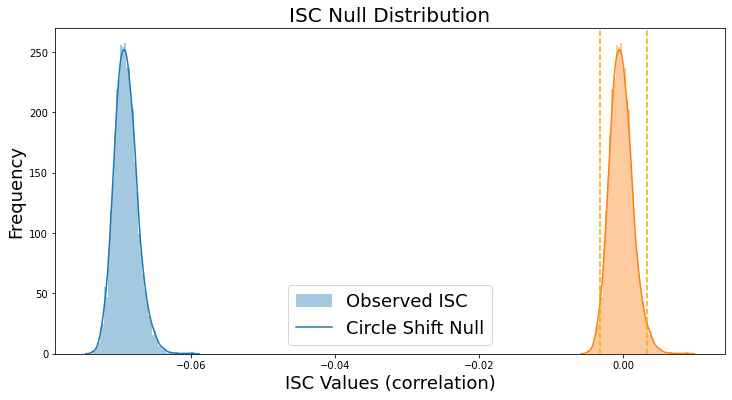

In [109]:
plt.figure(figsize=(12,6))
sns.distplot(stats_circle['null_distribution'] - stats_circle['isc'], kde=True, label='Bootstrap')

sns.distplot(stats_circle['null_distribution'], kde=True, label='Bootstrap')
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('ISC Values (correlation)', fontsize=18)
plt.title('ISC Null Distribution', fontsize=20)
plt.legend(['Observed ISC','Circle Shift Null'], fontsize=18)


plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange')
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange')



# Next steps
* Merge the subcortical and cortical datasets (make sure it is clear which is cortical and which is subcortical)
* Procede with the ISC analysis